Gambar Content (Tupai):


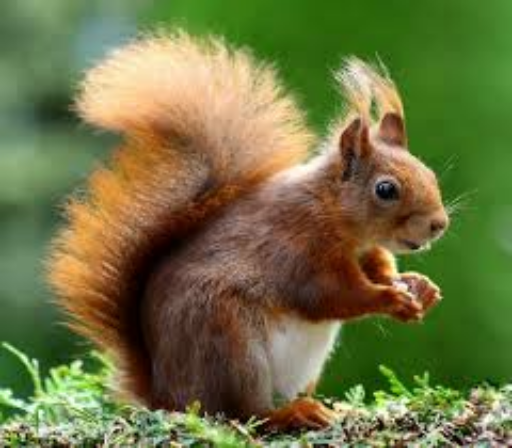

Gambar Style (Batik):


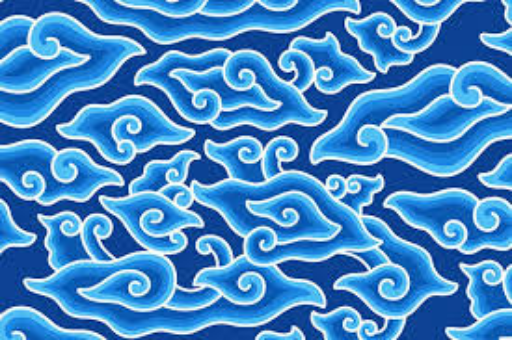

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Memulai Proses Style Transfer ---
Step 100/1000 selesai. Loss saat ini: 130275696.0000
Step 200/1000 selesai. Loss saat ini: 63416176.0000
Step 300/1000 selesai. Loss saat ini: 40894960.0000
Step 400/1000 selesai. Loss saat ini: 30772096.0000
Step 500/1000 selesai. Loss saat ini: 25428890.0000
Step 600/1000 selesai. Loss saat ini: 22247342.0000
Step 700/1000 selesai. Loss saat ini: 20133650.0000
Step 800/1000 selesai. Loss saat ini: 18662616.0000
Step 900/1000 selesai. Loss saat ini: 17590140.0000
Step 1000/1000 selesai. Loss saat ini: 16767164.0000
Total waktu: 5549.92 detik.

--- Gambar Hasil Style Transfer ---


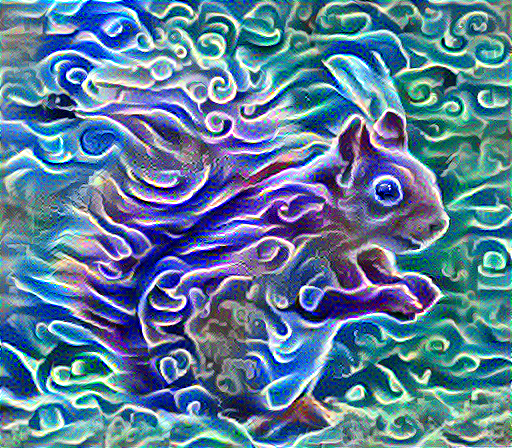

Gambar hasil telah disimpan sebagai 'tupai_batik_result.jpg'

Mengunduh hasil...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import time
import IPython.display as display
from tensorflow.keras.applications import VGG19

# --- 1. Konfigurasi dan Setup Gambar ---

# Tentukan jalur file gambar Anda
content_path = '/content/drive/MyDrive/tupai.jpg'
style_path = '/content/drive/MyDrive/batik.jpg'

# Fungsi untuk memuat dan memproses gambar
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # Tambahkan dimensi batch
    return img

# Fungsi untuk mengkonversi tensor hasil ke format gambar PIL
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Muat gambar content dan style
content_image = load_img(content_path)
style_image = load_img(style_path)

print("Gambar Content (Tupai):")
display.display(tensor_to_image(content_image))
print("Gambar Style (Batik):")
display.display(tensor_to_image(style_image))

# --- 2. Setup VGG19 dan Ekstraksi Fitur ---

# Layer yang akan digunakan untuk Content dan Style Loss
# Dari paper asli: A Neural Algorithm of Artistic Style
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Fungsi untuk membuat model Keras yang mengembalikan output dari layer-layer yang dipilih
def vgg_layers(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Setup ekstraktor fitur
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

# Fungsi untuk menghitung Gram Matrix (esensi Style Loss)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# --- 3. StyleContentModel: Menggabungkan Ekstraktor Fitur ---

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        # Preprocessing: VGG19 dilatih dengan mean dan std tertentu.
        self.vgg.preprocess = tf.keras.applications.vgg19.preprocess_input

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = self.vgg.preprocess(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]

        content_features = [content_output
                            for content_output in content_outputs]

        return {'content': content_features, 'style': style_features}

extractor = StyleContentModel(style_layers, content_layers)

# Ambil target fitur style dan content
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar hasil awal (kita inisialisasi dengan gambar konten)
image = tf.Variable(content_image)

# --- 4. Fungsi Loss dan Optimasi (Training Loop) ---

# Hyperparameters (bobot loss)
style_weight = 1e-2
content_weight = 1e4
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Fungsi Total Loss (gabungan Content dan Style Loss)
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style Loss (Mean Squared Error antara Gram Matrix target dan output)
    style_loss = tf.add_n([tf.reduce_mean((style_output - style_target)**2)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    style_loss *= style_weight / len(style_layers)

    # Content Loss (Mean Squared Error antara fitur content target dan output)
    content_loss = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                             for content_output, content_target in zip(content_outputs, content_targets)])
    content_loss *= content_weight / len(content_layers)

    return style_loss + content_loss

# Fungsi untuk menjaga nilai piksel tetap di rentang [0, 1]
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Fungsi langkah training (gradient descent)
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# --- 5. Jalankan Training Loop ---

epochs = 10
steps_per_epoch = 100
total_steps = epochs * steps_per_epoch

print("\n--- Memulai Proses Style Transfer ---")

start = time.time()

for n in range(total_steps):
    train_step(image)
    if (n + 1) % 100 == 0:
        print(f"Step {n + 1}/{total_steps} selesai. Loss saat ini: {style_content_loss(extractor(image)):.4f}")

end = time.time()
print(f"Total waktu: {end - start:.2f} detik.")

# --- 6. Hasil Akhir ---

print("\n--- Gambar Hasil Style Transfer ---")
final_image = tensor_to_image(image)
display.display(final_image)

# Simpan hasilnya
final_image.save('tupai_batik_result.jpg')
print("Gambar hasil telah disimpan sebagai 'tupai_batik_result.jpg'")

# BARIS KODE TAMBAHAN UNTUK DOWNLOAD OTOMATIS
try:
    from google.colab import files
    print("\nMengunduh hasil...")
    files.download('tupai_batik_result.jpg')
except ImportError:
    print("\nGoogle Colab environment not detected. Skipping automatic download.")